In [1]:
import sys

sys.path.insert(0, '../')

from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

from models.generator import Generator
from dataloader import GenomeDataset
from config import train as train_cf
from config import model as model_cf
from config import dataset as dt_cfg
from config import features
from utils.train_utils import get_mean_for_each_label

# Load Dataset

In [20]:
dataset_path = Path('../dataset/8_202.csv')
dataset = GenomeDataset(dt_cfg, dataset_path, features.SELECTED_FEATURES_64_8_202)
x = dataset.scaler.fit_transform(dataset.x)
y = dataset.y

label_means, label_stds, unique_labels = get_mean_for_each_label(x, y)

Label (0) mean is: (-0.12196031957864761), STD: (0.9749824404716492)
Label (1) mean is: (0.13466452062129974), STD: (1.0099493265151978)


# Plot real data PCA

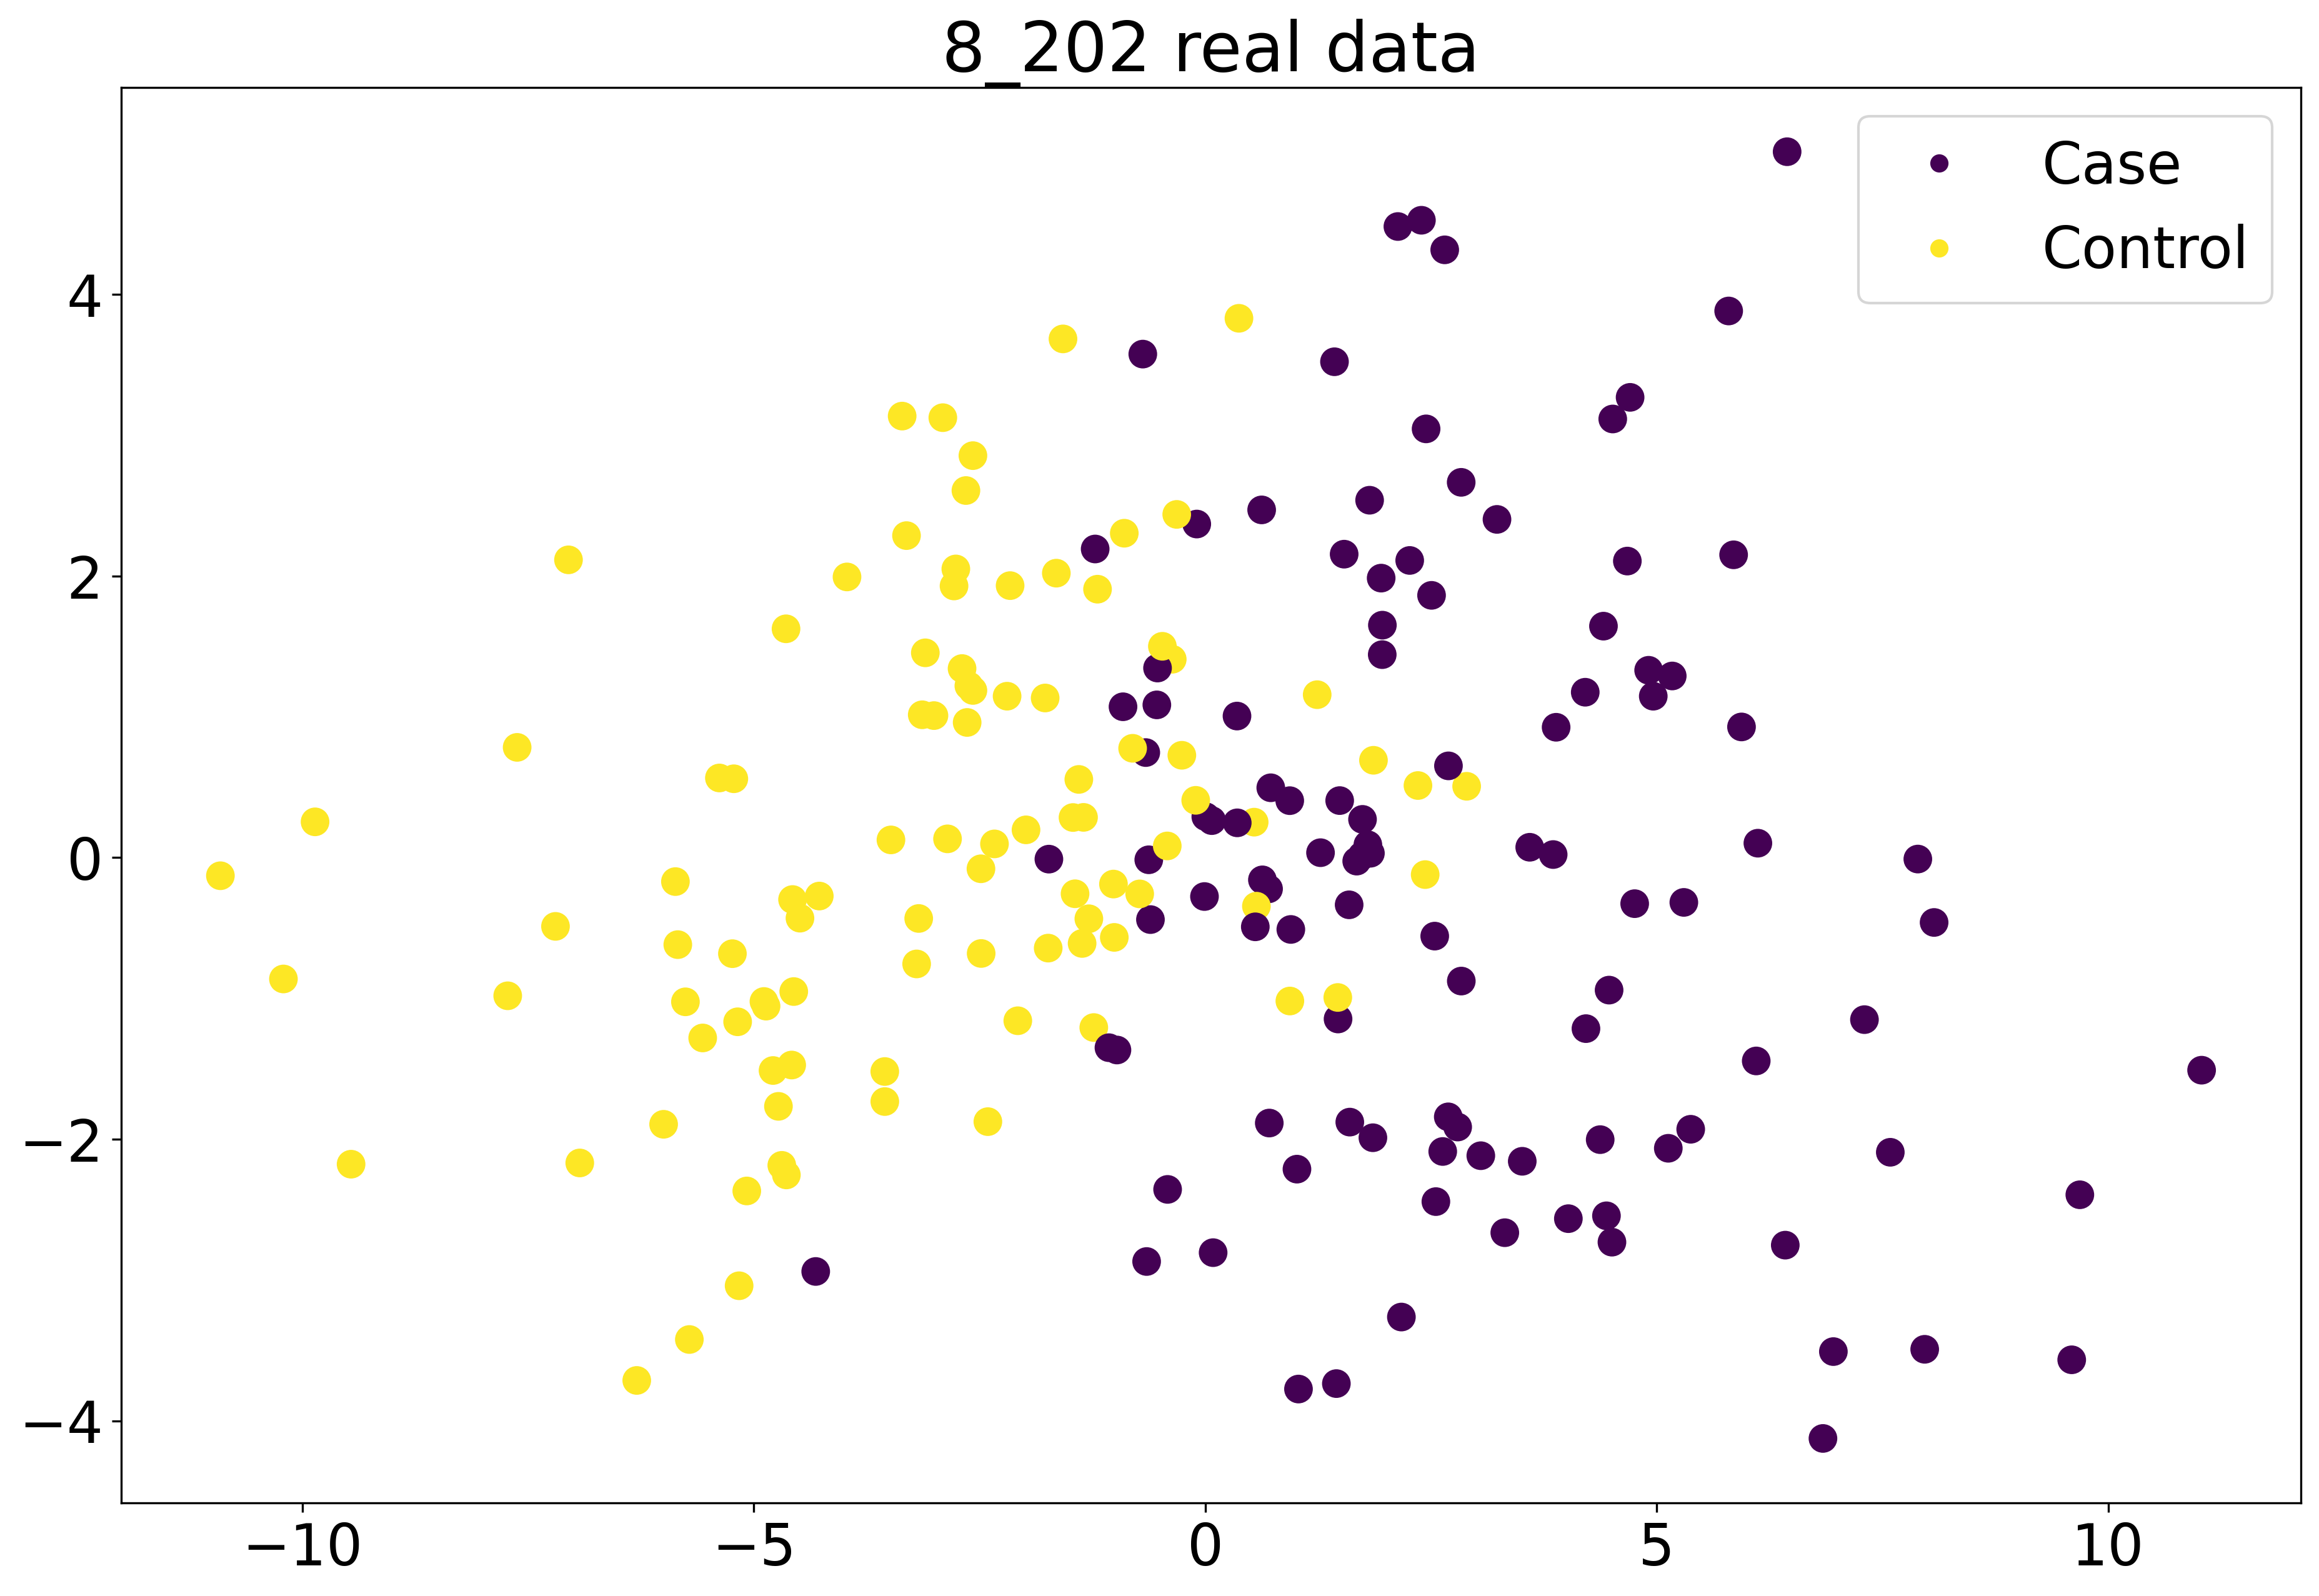

In [23]:
plt.rcParams.update({'font.size': 22})
pca = PCA(n_components=2)
pca.fit(x)
x_2d = pca.fit_transform(x)

plt.figure(figsize=(15, 10), dpi=300)
plot = plt.scatter(x_2d[:, 0], x_2d[:, 1],c = y, s=100)
plt.title('8_202 real data')
plt.legend(handles=plot.legend_elements()[0], labels=['Case', 'Control'])
plt.show()

# Load generators

In [24]:
import torch

In [25]:
gen_without_mean = Generator(
        in_features=train_cf.LATENT_SIZE,
        out_features=len(features.MRMR_SELECTED_FEATURES_64_1),
        hidden_layers=model_cf.G_HIDDEN_LAYERS,
)

gen_with_mean_std = Generator(
        in_features=train_cf.LATENT_SIZE,
        out_features=len(features.MRMR_SELECTED_FEATURES_64_1),
        hidden_layers=model_cf.G_HIDDEN_LAYERS,
)


basic_gan_without_mean = Generator(
        in_features=train_cf.LATENT_SIZE,
        out_features=len(features.MRMR_SELECTED_FEATURES_64_1),
        hidden_layers=model_cf.G_HIDDEN_LAYERS,
)

basic_gan_with_mean = Generator(
        in_features=train_cf.LATENT_SIZE,
        out_features=len(features.MRMR_SELECTED_FEATURES_64_1),
        hidden_layers=model_cf.G_HIDDEN_LAYERS,
)

gen_without_mean_path = Path('../SavedModels/2022-12-02 18_21_53acgan_without_mean_std_8_202.pth')
gen_with_mean_std_path = Path('../SavedModels/2022-12-02 18_25_32acgan_mean_std_8_202.pth')
basic_gan_without_mean_path = Path('../SavedModels/2022-12-02 18_31_38basic_gan_without_mean_std_8_202.pth')
basic_gan_with_mean_path = Path('../SavedModels/2022-12-02 18_33_10basic_gan_with_mean_std_8_202.pth')


gen_without_mean.load_state_dict(torch.load(gen_without_mean_path))
gen_with_mean_std.load_state_dict(torch.load(gen_with_mean_std_path))
basic_gan_without_mean.load_state_dict(torch.load(basic_gan_without_mean_path))
basic_gan_with_mean.load_state_dict(torch.load(basic_gan_with_mean_path))

<All keys matched successfully>

In [26]:
gen_without_mean.eval()
gen_with_mean_std.eval()
basic_gan_without_mean.eval()
basic_gan_with_mean.eval()

Generator(
  (layers): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=64, bias=True)
    (3): Tanh()
  )
)

In [27]:
noise = torch.randn(len(x), train_cf.LATENT_SIZE, dtype=torch.float32)
fake_classes = torch.randint(0, 2, (len(x), 1), dtype=torch.float32)

## Plot `Gen_without_mean_std` fake data distribution

In [28]:
_noise = noise + fake_classes
with torch.no_grad():
    generated_data = gen_without_mean(_noise)
generated_data = generated_data.cpu().numpy()

### Dimension Reduction

In [29]:
pca = PCA(n_components=2)
pca.fit(x)
x_2d = pca.fit_transform(x)
g_data_2d = pca.fit_transform(generated_data)

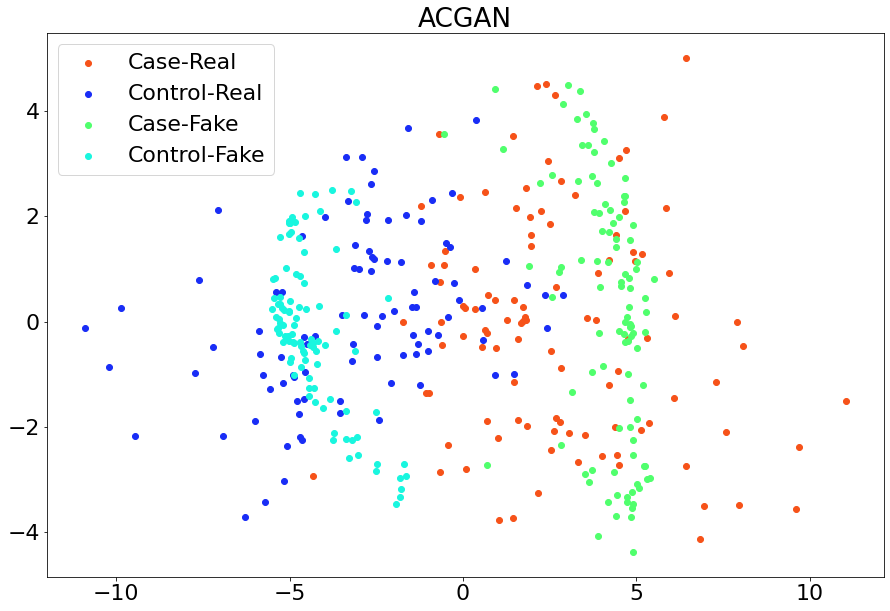

In [30]:
cdict = {0: '#F65219', 1: '#192DF6', 2: '#50FF6D', 3:'#19F6DF'}
labels = ['Case-Real', 'Control-Real', 'Case-Fake', 'Control-Fake']
group = np.append(y, fake_classes.cpu().numpy()+2)
x_data = np.append(x_2d[:, 0], g_data_2d[:, 0])
y_data = np.append(x_2d[:, 1], g_data_2d[:, 1])

plt.figure(figsize=(15, 10))
for g in np.unique(group):
    g = int(g)
    ix = np.where(group == g)
    plot = plt.scatter(x_data[ix], y_data[ix],c=cdict[g], label=labels[g], )

# plt.legend(handles=plot.legend_elements()[0], labels=['0', '1'])
plt.legend()
plt.title('ACGAN')
plt.show()

## Plot `gen_with_mean_std` fake data distribution

In [31]:
_noise = torch.zeros_like(noise)
for ii, l in enumerate(unique_labels):
    _noise[fake_classes.squeeze(1) == l] = (noise[fake_classes.squeeze(1) == l] + label_means[ii]) * \
                                          label_stds[ii]
with torch.no_grad():
    generated_data_with_mean_std = gen_with_mean_std(_noise)
generated_data_with_mean_std = generated_data_with_mean_std.cpu().numpy()

In [32]:
g_data_with_mean_std_2d = pca.fit_transform(generated_data_with_mean_std)

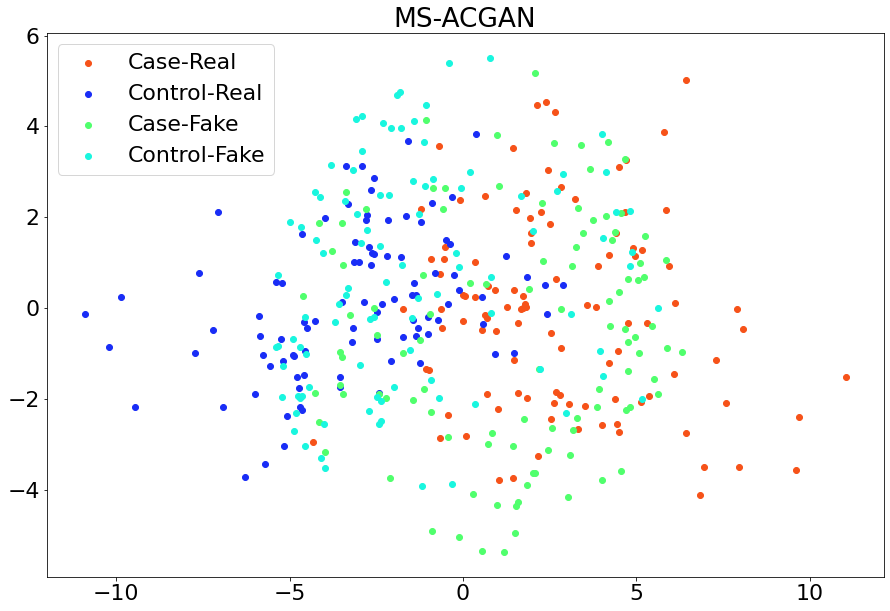

In [33]:
cdict = {0: '#F65219', 1: '#192DF6', 2: '#50FF6D', 3:'#19F6DF'}
labels = ['Case-Real', 'Control-Real', 'Case-Fake', 'Control-Fake']
group = np.append(y, fake_classes.cpu().numpy()+2)
x_data = np.append(x_2d[:, 0], g_data_with_mean_std_2d[:, 0])
y_data = np.append(x_2d[:, 1], g_data_with_mean_std_2d[:, 1])

plt.figure(figsize=(15, 10))
for g in np.unique(group):
    g = int(g)
    ix = np.where(group == g)
    plot = plt.scatter(x_data[ix], y_data[ix],c=cdict[g], label=labels[g], )

# plt.legend(handles=plot.legend_elements()[0], labels=['0', '1'])
plt.legend()
plt.title('MS-ACGAN')
plt.show()

# Plot basic GAN without mean

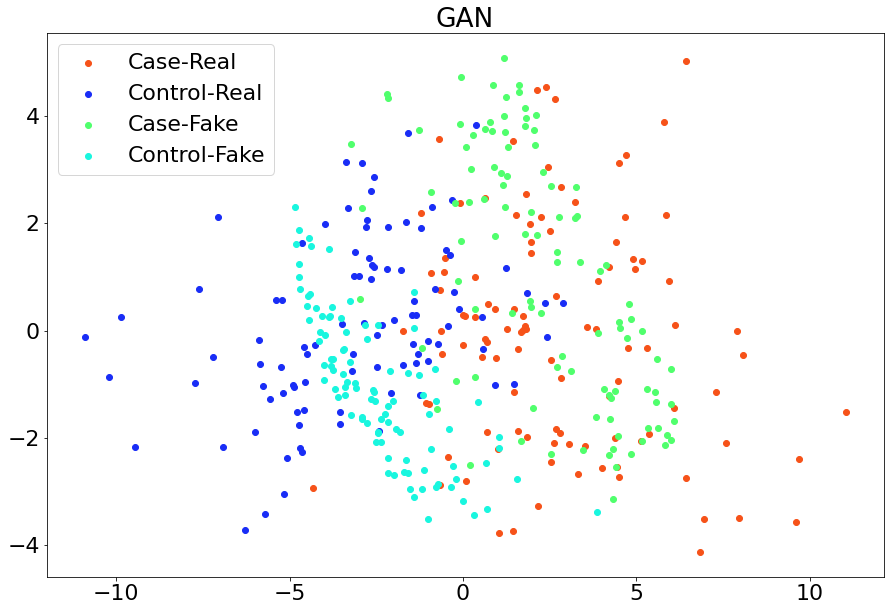

In [34]:
_noise = noise + fake_classes
with torch.no_grad():
    generated_data = basic_gan_without_mean(_noise)
generated_data = generated_data.cpu().numpy()

g_data_2d = pca.fit_transform(generated_data)

cdict = {0: '#F65219', 1: '#192DF6', 2: '#50FF6D', 3:'#19F6DF'}
labels = ['Case-Real', 'Control-Real', 'Case-Fake', 'Control-Fake']
group = np.append(y, fake_classes.cpu().numpy()+2)
x_data = np.append(x_2d[:, 0], g_data_2d[:, 0])
y_data = np.append(x_2d[:, 1], g_data_2d[:, 1])

plt.figure(figsize=(15, 10))
for g in np.unique(group):
    g = int(g)
    ix = np.where(group == g)
    plot = plt.scatter(x_data[ix], y_data[ix],c=cdict[g], label=labels[g], )

# plt.legend(handles=plot.legend_elements()[0], labels=['0', '1'])
plt.legend()
plt.title('GAN')
plt.show()

# Plot basic GAN with mean

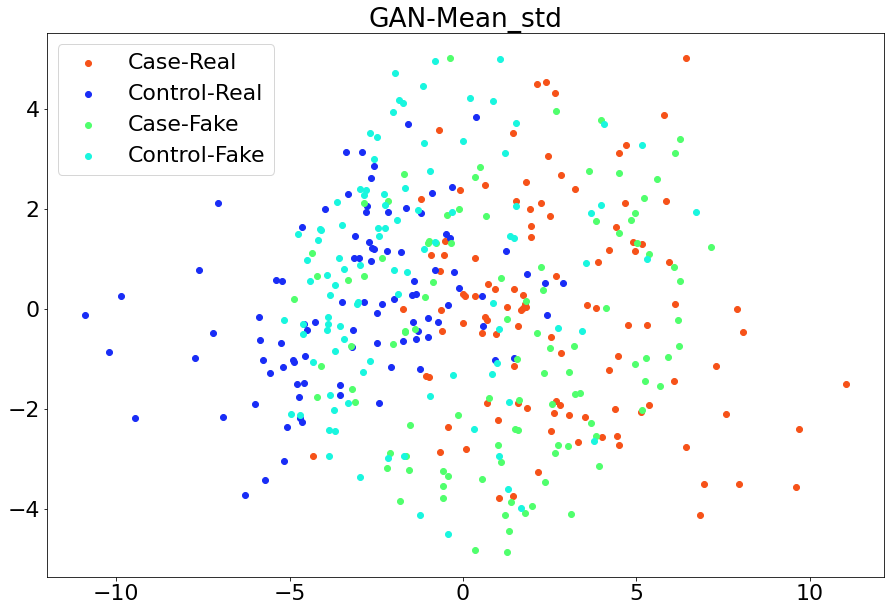

In [35]:
_noise = torch.zeros_like(noise)
for ii, l in enumerate(unique_labels):
    _noise[fake_classes.squeeze(1) == l] = (noise[fake_classes.squeeze(1) == l] + label_means[ii]) * \
                                          label_stds[ii]

with torch.no_grad():
    generated_data = basic_gan_with_mean(_noise)
generated_data = generated_data.cpu().numpy()

g_data_2d = pca.fit_transform(generated_data)

cdict = {0: '#F65219', 1: '#192DF6', 2: '#50FF6D', 3:'#19F6DF'}
labels = ['Case-Real', 'Control-Real', 'Case-Fake', 'Control-Fake']
group = np.append(y, fake_classes.cpu().numpy()+2)
x_data = np.append(x_2d[:, 0], g_data_2d[:, 0])
y_data = np.append(x_2d[:, 1], g_data_2d[:, 1])

plt.figure(figsize=(15, 10))
for g in np.unique(group):
    g = int(g)
    ix = np.where(group == g)
    plot = plt.scatter(x_data[ix], y_data[ix],c=cdict[g], label=labels[g], )

# plt.legend(handles=plot.legend_elements()[0], labels=['0', '1'])
plt.legend()
plt.title('GAN-Mean_std')
plt.show()

# Histogram


In [33]:
pca = PCA(n_components=1)
pca.fit(x)

x_1d = pca.fit_transform(x)

_noise_1 = torch.zeros_like(noise)
for ii, l in enumerate(unique_labels):
    _noise_1[fake_classes.squeeze(1) == l] = (noise[fake_classes.squeeze(1) == l] + label_means[ii]) * \
                                          label_stds[ii]
_noise_2 = noise + fake_classes


with torch.no_grad():
    fake_without_mean = gen_without_mean(_noise_2)
fake_without_mean = fake_without_mean.cpu().numpy()

with torch.no_grad():
    fake_with_mean_std = gen_with_mean_std(_noise_1)
fake_with_mean_std = fake_with_mean_std.cpu().numpy()

with torch.no_grad():
    fake_b_without_mean = basic_gan_without_mean(_noise_2)
fake_b_without_mean = fake_b_without_mean.cpu().numpy()

with torch.no_grad():
    fake_b_with_mean = basic_gan_with_mean(_noise_1)
fake_b_with_mean = fake_b_with_mean.cpu().numpy()



f1 = pca.fit_transform(fake_without_mean)
f2 = pca.fit_transform(fake_with_mean_std)
f3 = pca.fit_transform(fake_b_without_mean)
f4 = pca.fit_transform(fake_b_with_mean)

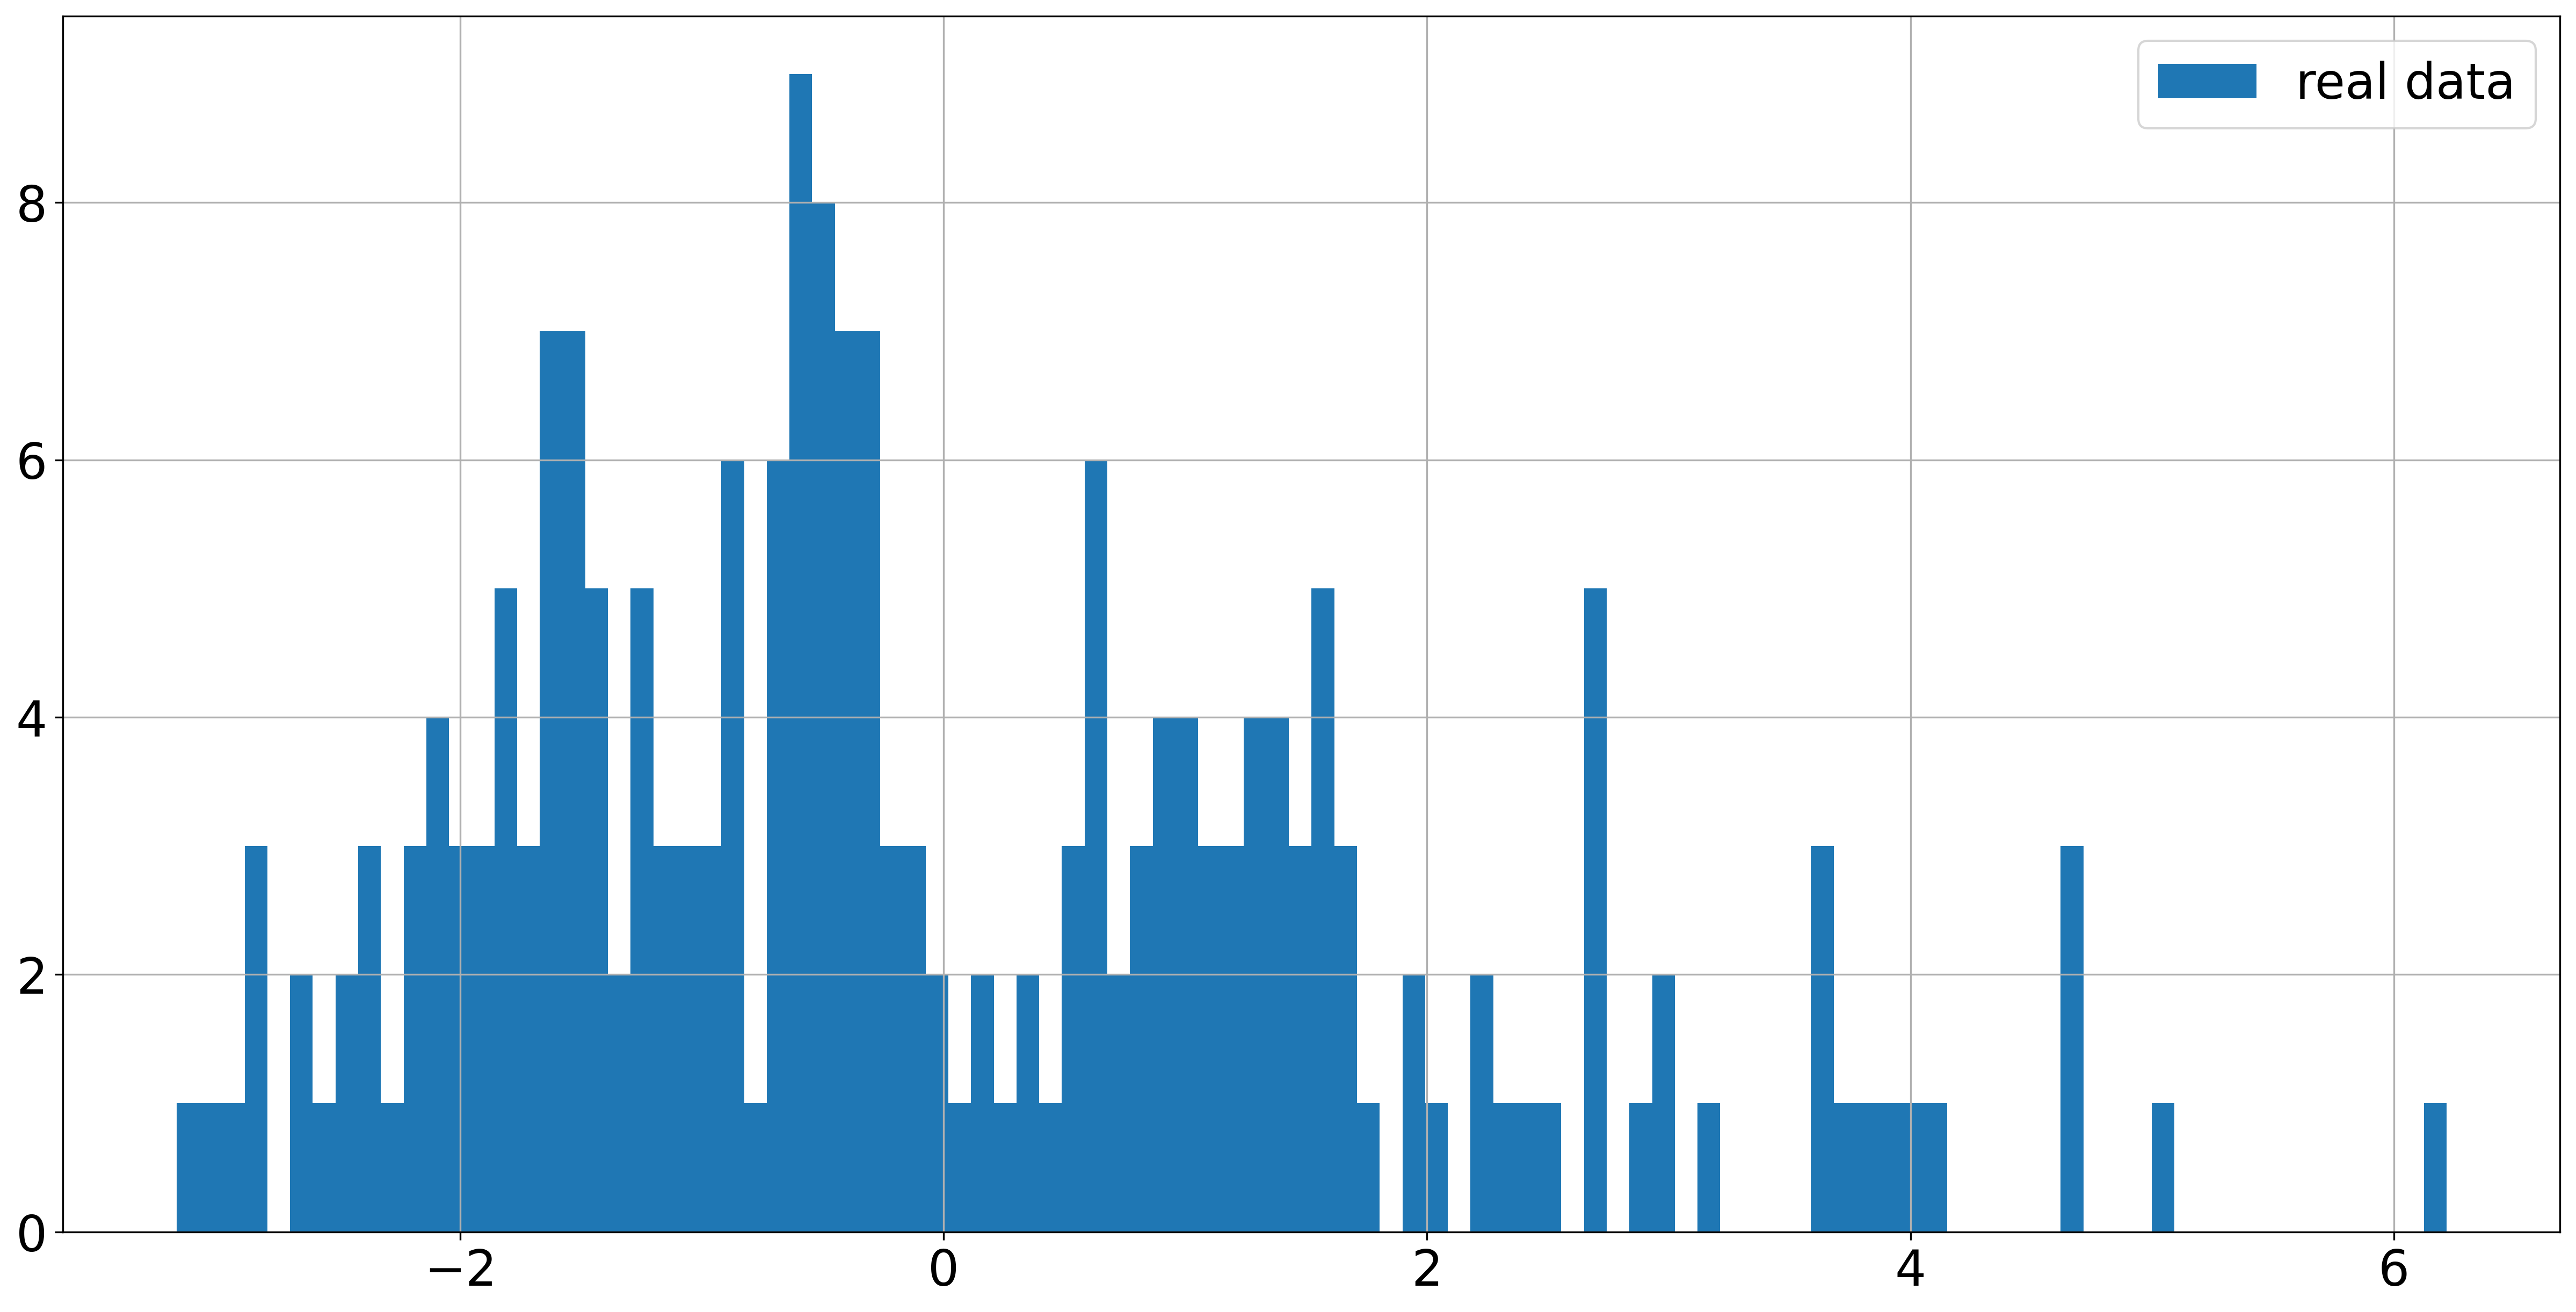

In [37]:
plt.figure(figsize=(20, 10), dpi=300)
# plt.subplots()
plt.hist(x_1d, bins=100, label='real data')
# plt.hist(f1, bins=100, label='ACGAN')
# plt.hist(f2, bins=100, alpha=0.9, label='MS-ACGAN')
# plt.hist(f3, bins=100, alpha=0.7, label='GAN')
# plt.hist(f4, bins=100, alpha=0.5, label='GAN+mean_std')
plt.legend()
plt.grid()
plt.show()